# Capstone2: Modeling - West Nile Virus (WNV) Prediction

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import auc, roc_curve, roc_auc_score
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('CleanData_ForModeling.csv')
df.head()

,Latitude,Longitude,NumMosquitos,Tmax,Tmin,Tavg,PrecipTotal,StnPressure,SeaLevel,AvgSpeed,WnvPresent,DayOfWeek,WeekNumber,IsWeekend,Quarter,Season,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS
0,41.644612,-87.604498,12,91.0,71.5,81.5,0.000,29.285,29.960,6.55,0,3,31,0,3,2,1,0,0
1,41.644612,-87.604498,52,91.5,72.5,82.5,0.685,29.085,29.750,8.90,0,1,32,0,3,2,1,0,0
2,41.644612,-87.604498,30,80.5,71.5,76.5,0.530,29.200,29.880,6.45,0,2,33,0,3,2,1,0,0
3,41.644612,-87.604498,4,90.0,69.5,80.0,0.625,29.260,29.935,8.95,0,2,34,0,3,2,1,0,0
4,41.644612,-87.604498,4,80.5,69.0,75.0,0.220,29.135,29.815,7.20,0,4,34,0,3,2,1,0,0


In [4]:
print(df['WnvPresent'].value_counts()[0])
print(df['WnvPresent'].value_counts()[1])

7782
387


### This clearly shows that the target class is very imbalence. So we want to use combination of oversampling technique and undersampling technique to balance them.

In [7]:
!pip install imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 1.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 3.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 2.9.0 requires visions[type_image_path]==0.5.0, but you have visions 0.7.5 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [10]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Define the SMOTE and RandomUnderSampler techniques
smote = SMOTE(sampling_strategy='minority', random_state=42)
rus = RandomUnderSampler(sampling_strategy='majority', random_state=42)

# Create a pipeline with SMOTE and RandomUnderSampler
sampling_pipeline = Pipeline([
    ('smote', smote),
    ('rus', rus)
])

# Apply the sampling techniques to balance the dataset
X = df.drop(columns=['WnvPresent'])
y = df['WnvPresent']
X_resampled, y_resampled = sampling_pipeline.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

In [11]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10894, 18)
(4670, 18)
(10894,)
(4670,)


### This is the classification problem of supervised learning. I will test following different models to this problem.

# 1. Logistic Regression

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve

In [13]:
C_param_range = [0.001,0.01,0.1,1,10,100]

table = pd.DataFrame(columns = ['C_parameter','Accuracy'])
table['C_parameter'] = C_param_range


table2 = pd.DataFrame(columns = ['C_parameter','ROC_AUC_Score'])
table2['C_parameter'] = C_param_range
j = 0
for i in C_param_range:
    
    # Apply logistic regression model to training data
    Logreg = LogisticRegression(penalty = 'l2', C = i,random_state = 40)
    Logreg.fit(X_train,y_train)
    
    # Predict using model
    y_pred_lr = Logreg.predict(X_test)
    
    # Saving accuracy score in table
    table.iloc[j,1] = accuracy_score(y_test,y_pred_lr)
    
    
    y_scores_lr = Logreg.predict_proba(X_test)[:,1]
    table2.iloc[j,1] = roc_auc_score(y_test,y_scores_lr)
    j += 1
    
print(table)  
print(table2)

   C_parameter  Accuracy
0        0.001  0.731263
1        0.010  0.768522
2        0.100   0.77045
3        1.000  0.759957
4       10.000  0.765953
5      100.000  0.768522
   C_parameter ROC_AUC_Score
0        0.001      0.807105
1        0.010      0.867768
2        0.100       0.86699
3        1.000      0.858335
4       10.000       0.86311
5      100.000      0.858776


In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_curve, roc_auc_score
Logreg = LogisticRegression(penalty = 'l2', C = 0.01,random_state = 40)
Logreg.fit(X_train,y_train)
y_pred_lr = Logreg.predict(X_test)
y_scores_lr = Logreg.predict_proba(X_test)
y_scores_lr = y_scores_lr[:,1]
auroc_lr = roc_auc_score(y_test, y_scores_lr)
print(auroc_lr)
cnf_matrix = confusion_matrix(y_test, y_pred_lr)
print(cnf_matrix)

0.8677681584739545
[[1781  569]
 [ 512 1808]]


### This shows that C parameter value of 0.01 and 0.1 are giving better ROC AUC score.

In [19]:
from sklearn.model_selection import cross_val_score
cv_scores_test= cross_val_score(Logreg,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(Logreg,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_lr_test= cv_scores_test.mean()
cv_scores_lr_train= cv_scores_train.mean()
cv_scores_std_test_lr= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_lr_test))
print ('Mean cross validation train score: ' +str(cv_scores_lr_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_lr))

[0.83009905 0.84088866 0.83274486 0.8273661  0.84895451]
Mean cross validation test score: 0.8360106382978723
Mean cross validation train score: 0.8760870691903841
Standard deviation in cv test scores: 0.007895304703304268


# 2. K-Nearest Neighbor(KNN)

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

In [22]:
N_neighbors_range = [3,5,10,25,50,100]

table = pd.DataFrame(columns = ['N_neighbors','Accuracy'])
table['N_neighbors'] = N_neighbors_range

table2 = pd.DataFrame(columns = ['N_neighbors','ROC_AUC_Score'])
table2['N_neighbors'] = N_neighbors_range

j = 0
for i in N_neighbors_range:
    
    # Apply logistic regression model to training data
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    
    # Predict using model
    pred_knn = knn.predict(X_test)
    
    # Saving accuracy score in table
    table.iloc[j,1] = accuracy_score(y_test,pred_knn)
    y_scores_knn = knn.predict_proba(X_test)[:,1]
#    auroc_lr = roc_auc_score(y_test, y_scores_lr)
    table2.iloc[j,1] = roc_auc_score(y_test,y_scores_knn)
    j += 1
    
print(table)
print(table2)

   N_neighbors  Accuracy
0            3  0.921199
1            5  0.904069
2           10  0.888865
3           25  0.847323
4           50  0.824411
5          100  0.807709
   N_neighbors ROC_AUC_Score
0            3      0.961649
1            5      0.962593
2           10      0.953637
3           25      0.931565
4           50      0.916359
5          100      0.894686


### Looks like Accuracy is good for n_neighbors=5. Neither too large not too small n_neighbors is good.

In [23]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
pred_knn= knn.predict(X_test)
print(classification_report(y_test, pred_knn))
Accuracy_knn=knn.score(X_test,y_test)
y_scores_knn = knn.predict_proba(X_test)[:,1]
auroc_knn = roc_auc_score(y_test, y_scores_knn)
print(auroc_knn)
print(confusion_matrix(y_test, pred_knn))

              precision    recall  f1-score   support

           0       0.96      0.85      0.90      2350
           1       0.86      0.96      0.91      2320

    accuracy                           0.90      4670
   macro avg       0.91      0.90      0.90      4670
weighted avg       0.91      0.90      0.90      4670

0.9625929933969185
[[1987  363]
 [  85 2235]]


In [24]:
from sklearn.model_selection import cross_val_score
cv_scores_test= cross_val_score(knn,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(knn,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_knn_test= cv_scores_test.mean()
cv_scores_knn_train= cv_scores_train.mean()
cv_scores_std_test_knn= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_knn_test))
print ('Mean cross validation train score: ' +str(cv_scores_knn_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_knn))

[0.91093635 0.93108263 0.92375275 0.92221203 0.93294433]
Mean cross validation test score: 0.9241856199559795
Mean cross validation train score: 0.9527821906708394
Standard deviation in cv test scores: 0.007796271869324786


# 3. Support Vector Machine (SVM)

In [41]:
from sklearn.svm import SVC
svm = SVC(kernel='linear')
from sklearn.model_selection import train_test_split
X = df.drop(columns=['WnvPresent'])
y = df['WnvPresent']
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
svm.fit(X_train, y_train)
pred_svm= svm.predict(X_test)
print(confusion_matrix(y_test, pred_svm))
Accuracy_svm=svm.score(X_test,y_test)
y_scores_svm = knn.predict_proba(X_test)[:,1]
auroc_svm = roc_auc_score(y_test, y_scores_svm)
print(auroc_svm)

[[2102  248]
 [ 639 1681]]
0.9625929933969185


In [27]:
from sklearn.model_selection import cross_val_score
cv_scores_test= cross_val_score(svm,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(svm,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_svm_test= cv_scores_test.mean()
cv_scores_svm_train= cv_scores_train.mean()
cv_scores_std_test_svm= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_svm_test))
print ('Mean cross validation train score: ' +str(cv_scores_svm_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_svm))

[0.89085657 0.90369589 0.87118947 0.88273569 0.8948872 ]
Mean cross validation test score: 0.8886729640498899
Mean cross validation train score: 0.8953735845308686
Standard deviation in cv test scores: 0.011045332480589722


# 4. Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
from sklearn.model_selection import train_test_split
X = df.drop(columns=['WnvPresent'])
y = df['WnvPresent']
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
rf.fit(X_train, y_train)
pred_rf= rf.predict(X_test)
#print(accuracy_score(y_test, pred_rf))
Accuracy_rf=rf.score(X_test,y_test)
#print(Accuracy_rf)
print(confusion_matrix(y_test, pred_rf))
y_scores_rf = rf.predict_proba(X_test)[:,1]
auroc_rf = roc_auc_score(y_test, y_scores_rf)
print(auroc_rf)

[[1989  361]
 [ 202 2118]]
0.9479153521643432


In [29]:
from sklearn.model_selection import cross_val_score
cv_scores_test= cross_val_score(rf,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(rf,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_rf_test= cv_scores_test.mean()
cv_scores_rf_train= cv_scores_train.mean()
cv_scores_std_test_rf= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_rf_test))
print ('Mean cross validation train score: ' +str(cv_scores_rf_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_rf))

[0.94643709 0.94866104 0.94760409 0.94336253 0.95230191]
Mean cross validation test score: 0.9476733308877476
Mean cross validation train score: 0.9457199913417587
Standard deviation in cv test scores: 0.0029160045631184215


# 5. Gradient Boosting

In [30]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
X = df.drop(columns=['WnvPresent'])
y = df['WnvPresent']
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbc.fit(X_train, y_train)
pred_gbc = gbc.predict(X_test)
#print(accuracy_score(y_test, pred_gbc))
Accuracy_gbc=gbc.score(X_test,y_test)
#print(Accuracy_gbc)
print(confusion_matrix(y_test, pred_gbc))

y_scores_gbc = gbc.predict_proba(X_test)[:,1]
auroc_gbc = roc_auc_score(y_test, y_scores_gbc)
print(auroc_gbc)

[[2193  157]
 [ 156 2164]]
0.9835096294937637


In [31]:
from sklearn.model_selection import cross_val_score
cv_scores_test= cross_val_score(gbc,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(gbc,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_gbc_test= cv_scores_test.mean()
cv_scores_gbc_train= cv_scores_train.mean()
cv_scores_std_test_gbc= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_gbc_test))
print ('Mean cross validation train score: ' +str(cv_scores_gbc_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_gbc))

[0.97949835 0.98114453 0.97981245 0.98028247 0.98151825]
Mean cross validation test score: 0.9804512105649303
Mean cross validation train score: 0.9810966330404302
Standard deviation in cv test scores: 0.000769896174384105


# 6. Naive Bayes

In [32]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
X = df.drop(columns=['WnvPresent'])
y = df['WnvPresent']
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
nb = GaussianNB()
nb.fit(X_train, y_train)
pred_nb = nb.predict(X_test)
#print(accuracy_score(y_test, pred_nb))
Accuracy_nb=nb.score(X_test,y_test)
#print(Accuracy_nb)
print(confusion_matrix(y_test, pred_nb))

y_scores_nb = nb.predict_proba(X_test)[:,1]
auroc_nb = roc_auc_score(y_test, y_scores_nb)
print(auroc_nb)

[[1287 1063]
 [ 192 2128]]
0.8788367571533382


In [33]:
from sklearn.model_selection import cross_val_score
cv_scores_test= cross_val_score(nb,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(nb,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_nb_test= cv_scores_test.mean()
cv_scores_nb_train= cv_scores_train.mean()
cv_scores_std_test_nb= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_nb_test))
print ('Mean cross validation train score: ' +str(cv_scores_nb_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_nb))

[0.87315205 0.88186904 0.87119406 0.86048239 0.88926999]
Mean cross validation test score: 0.8751935069699194
Mean cross validation train score: 0.8699778049219329
Standard deviation in cv test scores: 0.009790712059431786


# XGBoost Model

In [76]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 6.3 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [39]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X = df.drop(columns=['WnvPresent'])
y = df['WnvPresent']
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
params = {
    'objective': 'binary:logistic', 
    'max_depth': 3,                  
    'learning_rate': 0.1,            
    'n_estimators': 100,             
    'eval_metric': 'logloss'        
}
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

xgb_model = xgb.train(params, dtrain, num_boost_round=100)

raw_scores = xgb_model.predict(dtest)

# Apply sigmoid function to get probabilities
probabilities = 1 / (1 + np.exp(-raw_scores))

auroc_xgb = roc_auc_score(y_test, probabilities)
print(auroc_xgb)

0.9826401320616287


# Comparison of Models

In [46]:
models = [ 'Logistic Regression','KNN', 'SVM', 'Random Forest','Gradient Boost', 'Naive Bayes']
models2 = [ 'Logistic Regression','KNN','SVM', 'Random Forest','Gradient Boost', 'Naive Bayes', 'XGBoost']
score_test= [  cv_scores_lr_test,cv_scores_knn_test,cv_scores_svm_test, cv_scores_rf_test,cv_scores_gbc_test,cv_scores_nb_test]
score_train= [  cv_scores_lr_train,cv_scores_knn_train,cv_scores_svm_train, cv_scores_rf_train,cv_scores_gbc_train,cv_scores_nb_train]
Accuracy_score = [Accuracy_lr,Accuracy_knn, Accuracy_svm, Accuracy_rf,Accuracy_gbc,Accuracy_nb]

auroc_score = [auroc_lr, auroc_knn, auroc_svm, auroc_rf, auroc_gbc, auroc_nb, auroc_xgb]

score_tab_auroc = pd.DataFrame(list(zip(models2, auroc_score)), 
               columns =['Algorithm', 'ROC-AUC score']) 

score_tab_acc = pd.DataFrame(list(zip(models2, Accuracy_score)), 
               columns =['Algorithm', 'Model accuracy score']) 

score_tab = pd.DataFrame(list(zip(models, score_train, score_test)), 
               columns =['Algorithm','train score', 'test score' ]) 
print(score_tab_acc)

print(score_tab)

print(score_tab_auroc)

             Algorithm  Model accuracy score
0  Logistic Regression              0.768522
1                  KNN              0.904069
2                  SVM              0.810064
3        Random Forest              0.879443
4       Gradient Boost              0.932976
5          Naive Bayes              0.731263
             Algorithm  train score  test score
0  Logistic Regression     0.876087    0.836011
1                  KNN     0.952782    0.924186
2                  SVM     0.895374    0.888673
3        Random Forest     0.945720    0.947673
4       Gradient Boost     0.981097    0.980451
5          Naive Bayes     0.869978    0.875194
             Algorithm  ROC-AUC score
0  Logistic Regression       0.867768
1                  KNN       0.962593
2                  SVM       0.962593
3        Random Forest       0.947915
4       Gradient Boost       0.983510
5          Naive Bayes       0.878837
6              XGBoost       0.982640


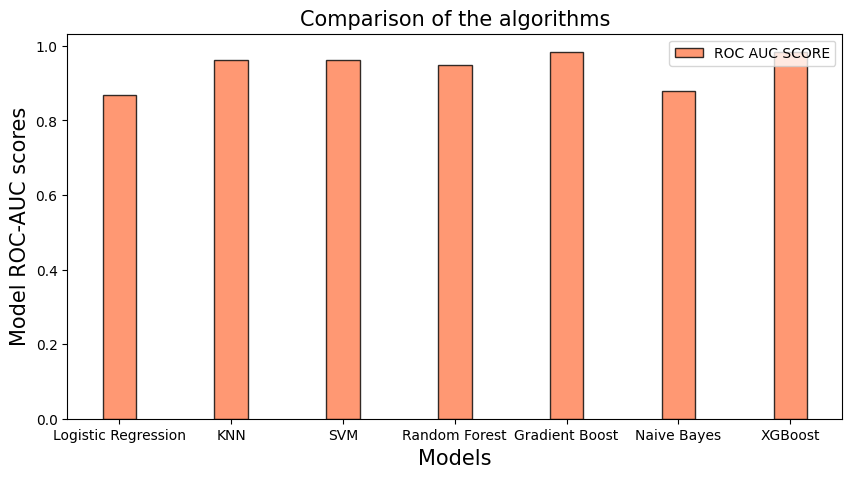

In [44]:
plt.figure(figsize=(10,5))
plt.bar(models2,auroc_score,color='coral',alpha=0.8,label='ROC AUC SCORE',edgecolor='k',width=0.3)
plt.xlabel('Models',fontsize=15)
plt.ylabel ('Model ROC-AUC scores',fontsize=15)
plt.title('Comparison of the algorithms',fontsize=15)
plt.legend()
plt.show()

### Gradient Boost model turned out to be the  best model with ROC AUC score of 0.983510.  This model also has largets train score, test score and accuracy score.

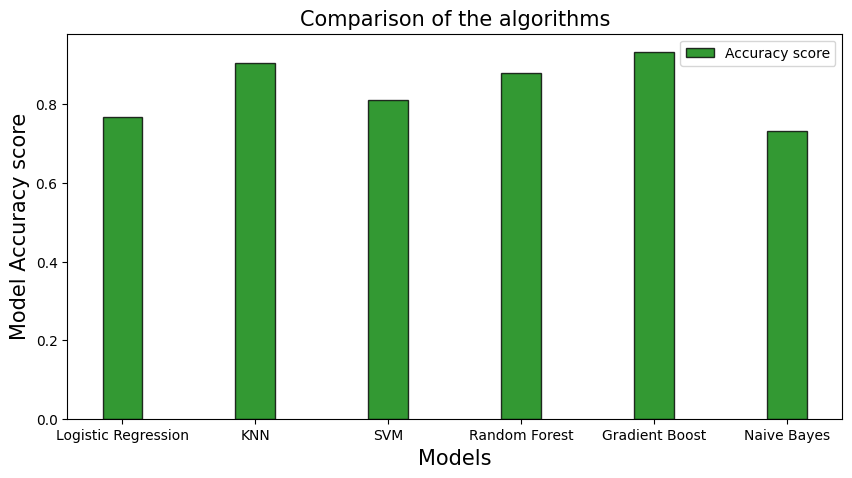

In [45]:
plt.figure(figsize=(10,5))
plt.bar(models,Accuracy_score,color='green',alpha=0.8,label='Accuracy score',edgecolor='k',width=0.3)
plt.xlabel('Models',fontsize=15)
plt.ylabel ('Model Accuracy score',fontsize=15)
plt.title('Comparison of the algorithms',fontsize=15)
plt.legend()
plt.show()

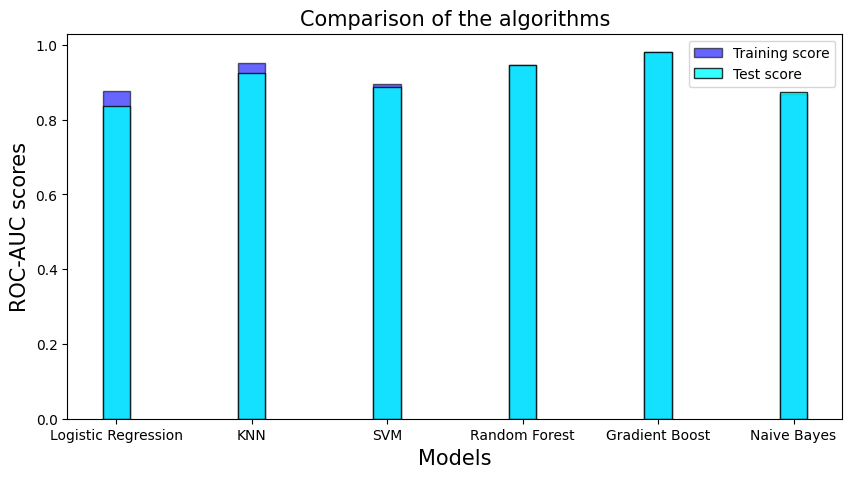

In [52]:
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('ROC-AUC scores',fontsize=15)
plt.title('Comparison of the algorithms',fontsize=15)
plt.bar(models,score_train,color='b',alpha=0.6,label='Training score',edgecolor='k',width=0.2)
plt.bar(models,score_test,color='cyan',alpha=0.8,label='Test score',edgecolor='k',width=0.2)
#plt.xticks([1, 2,3,4,5, 6], models)
plt.legend()
plt.savefig("27.png")
plt.show()

#  Gradient Boosting Models is performing better. Next, I will do Hyperparameter Tuning with Gradient Boosting.

## Parameter Tuning

In [54]:
GB = GradientBoostingClassifier()
gb_param = {
        'loss' : ["deviance"],
        'n_estimators' : [100,200,300],
        'learning_rate': [0.1, 0.05, 0.01],
        'max_depth': [4, 8],
        'min_samples_leaf': [100,150],
        'max_features': [0.3, 0.1] 
        }

gsGB = GridSearchCV(GB, param_grid = gb_param, cv=3, scoring="accuracy", verbose = 1)
gsGB.fit(X_train,y_train)
print(gsGB.best_estimator_)
print(gsGB.best_score_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
GradientBoostingClassifier(max_depth=8, max_features=0.3, min_samples_leaf=100,
                           n_estimators=300)
0.9628238247413466


## Fitting the model with optimal parameters

In [56]:
GB = GradientBoostingClassifier(max_depth=8, max_features=0.3, min_samples_leaf=100,
                           n_estimators=300)
GB.fit(X_train, y_train)
y_predictions_GB = GB.predict(X_test)
acc_GB = accuracy_score(y_test, y_predictions_GB)
cv_GB = cross_val_score(GB, X_test, y_test,scoring='roc_auc').mean()
print(acc_GB)
print(cv_GB)

y_scores_GB = GB.predict_proba(X_test)[:,1]
auroc_GB = roc_auc_score(y_test, y_scores_GB)
print(auroc_GB)

0.9732334047109208
0.9894185619955979
0.9963860968451944


### Hence performing hyperparameter tuning ROC AUC score increased from 0.983510 to 0.9963860968451944.

### ROC Curve

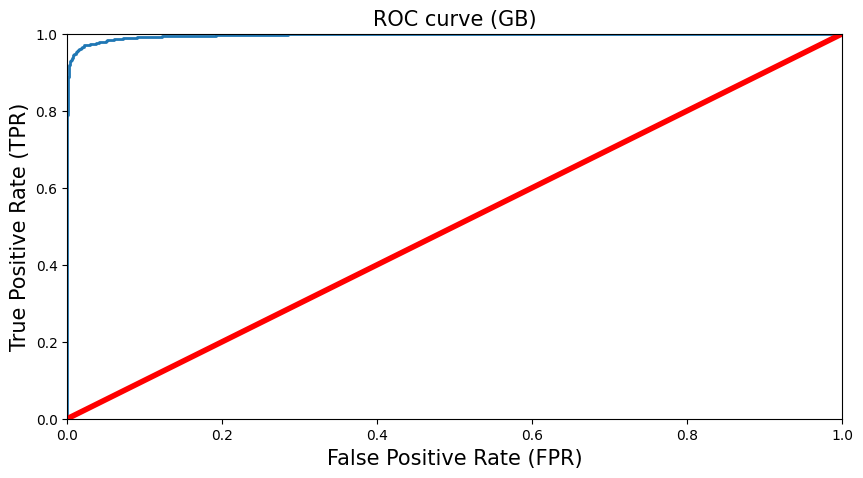

In [61]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores_gb)
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=15)
    plt.ylabel('True Positive Rate (TPR)', fontsize=15)
    plt.title('ROC curve (GB)',fontsize=15)

plt.figure(figsize=(10, 5))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.savefig("31.png")
plt.show()

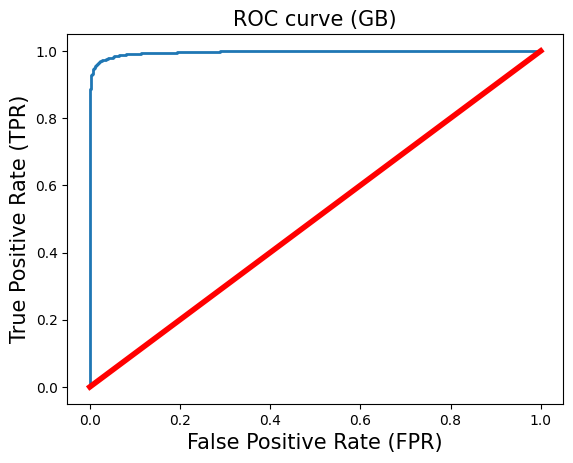

<Figure size 1000x500 with 0 Axes>

In [65]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores_gb)

plt.plot(false_positive_rate, true_positive_rate, linewidth=2)
plt.plot([0, 1], [0, 1], 'r', linewidth=4)
plt.xlabel('False Positive Rate (FPR)', fontsize=15)
plt.ylabel('True Positive Rate (TPR)', fontsize=15)
plt.title('ROC curve (GB)',fontsize=15)

plt.figure(figsize=(10, 5))
plt.savefig("31.png")
plt.show()

## Extracting Feature Importances

In [57]:
df

,Latitude,Longitude,NumMosquitos,Tmax,Tmin,Tavg,PrecipTotal,StnPressure,SeaLevel,AvgSpeed,WnvPresent,DayOfWeek,WeekNumber,IsWeekend,Quarter,Season,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS
0,41.644612,-87.604498,12,91.0,71.5,81.5,0.000,29.285,29.960,6.55,0,3,31,0,3,2,1,0,0
1,41.644612,-87.604498,52,91.5,72.5,82.5,0.685,29.085,29.750,8.90,0,1,32,0,3,2,1,0,0
2,41.644612,-87.604498,30,80.5,71.5,76.5,0.530,29.200,29.880,6.45,0,2,33,0,3,2,1,0,0
3,41.644612,-87.604498,4,90.0,69.5,80.0,0.625,29.260,29.935,8.95,0,2,34,0,3,2,1,0,0
4,41.644612,-87.604498,4,80.5,69.0,75.0,0.220,29.135,29.815,7.20,0,4,34,0,3,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8164,42.017430,-87.687769,4,70.0,51.0,60.5,0.480,29.235,29.930,7.75,0,4,23,0,2,2,0,0,1
8165,42.017430,-87.687769,4,82.0,62.0,72.0,0.000,29.155,29.820,6.40,0,4,24,0,2,2,0,0,1
8166,42.017430,-87.687769,2,88.5,63.0,76.0,0.030,29.310,29.995,10.00,0,3,26,0,2,2,0,0,1
8167,42.017430,-87.687769,46,89.0,70.5,80.0,0.260,29.150,29.815,8.25,0,0,28,0,3,2,0,0,1


                          Features  Importance scores
0                         Latitude           0.000000
1                        Longitude           0.007790
2                     NumMosquitos           0.013524
3                             Tmax           0.016907
4                             Tmin           0.019560
5                             Tavg           0.030393
6                      PrecipTotal           0.030890
7                      StnPressure           0.033231
8                         SeaLevel           0.037664
9                         AvgSpeed           0.037724
10                       DayOfWeek           0.038552
11                      WeekNumber           0.046223
12                       IsWeekend           0.046312
13                         Quarter           0.072385
14                          Season           0.074737
15           Species_CULEX PIPIENS           0.098923
16  Species_CULEX PIPIENS/RESTUANS           0.137242
17          Species_CULEX RE

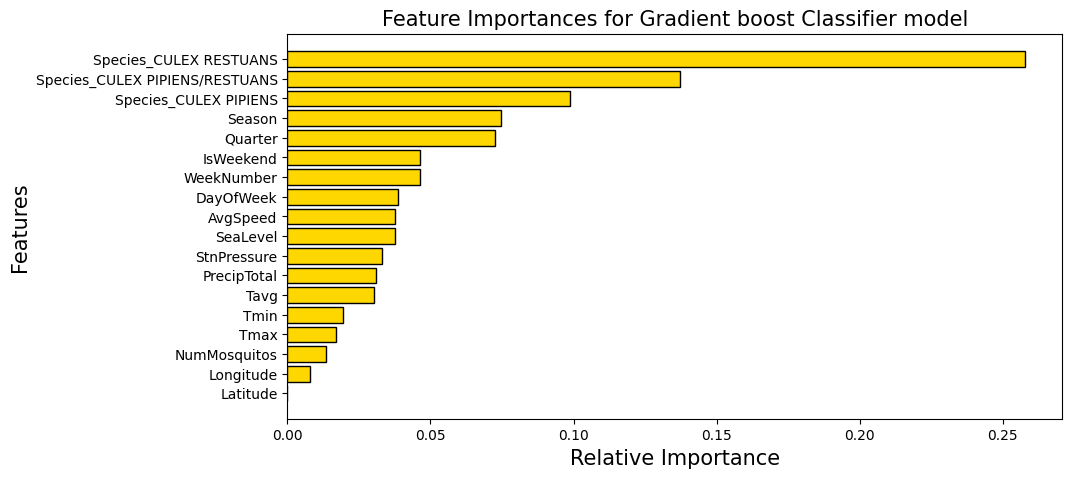

In [58]:
features = X
importances = list(GB.feature_importances_)
imp=np.sort(importances)
tab=pd.DataFrame(list(zip(X,imp)),columns =['Features', 'Importance scores']) 
print(tab)

#visually:
plt.figure(figsize=(10,5))
#indices = np.argsort(importances)
index = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
_=plt.barh(index,imp, align='center',color='gold',edgecolor='k')
plt.xlabel('Relative Importance',fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.yticks(index, features)
plt.title('Feature Importances for Gradient boost Classifier model',fontsize=15)
plt.savefig("29.png")
plt.show()